In [1]:
%cd /home/rguillaume/developpements/Publications/2024_Guillaume-Castel_PatternEffect_on_TCR/reviews

/home/rguillaume/developpements/Publications/2024_Guillaume-Castel_PatternEffect_on_TCR/reviews


In [2]:
import xarray as xr 
import cmipaccess as cmip
import numpy as np

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from xmip.preprocessing import correct_lon
import pandas as pd
from scipy.optimize import curve_fit
plt.style.use('robin')
import cartopy.feature as cfeat

from matplotlib.font_manager import fontManager
fontManager.addfont('../Arial.ttf')
fontManager.addfont('../Arial-bold.ttf')
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['mathtext.fontset'] = 'dejavuserif'


pica = 1/6
small_fig = 19*pica
med1_fig = 27*pica
med2_fig = 33*pica
large_fig = 39*pica

In [27]:
ds = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/full_preprocessed.nc').isel(time=range(0,150))


In [11]:
lbd_u = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/lbd_pi.nc')
lbd_u_amip = lbd_u.dN/lbd_u.dTAS
lbd_u_amip

<xarray.DataArray (model: 12, method: 3)> Size: 288B
array([[-1.70503965, -1.57287205,         nan],
       [-1.7034001 , -1.61732052, -1.38555156],
       [-1.50542614, -1.23053249, -1.22860682],
       [-1.08536455, -1.06008955,         nan],
       [        nan, -1.41325721,         nan],
       [-1.69136186, -1.59452309,         nan],
       [        nan, -1.67061192,         nan],
       [-1.27207242, -1.19900141, -1.19376308],
       [-1.44619056, -1.1585496 , -1.21237223],
       [        nan, -1.74694676,         nan],
       [-1.6826932 , -1.59803705,         nan],
       [        nan, -1.63637739,         nan]])
Coordinates:
  * method   (method) <U9 108B 'amip-m4K' 'amip-p4K' 'piSST-pxK'
  * model    (model) <U15 720B 'BCC-CSM2-MR' 'CESM2' ... 'NorESM2-LM'

In [147]:
df_alb = pd.read_csv('https://raw.githubusercontent.com/mzelinka/cmip56_forcing_feedback_ecs/master/CMIP6_ECS_ERF_fbks.txt', delim_whitespace=True, header=7, skipfooter=5, engine='python').iloc[1:]

alb = df_alb.groupby('MODEL').ALB.mean()
surf_albedo_feedback = alb.loc[lbd_u_amip.model.values].to_xarray().rename(MODEL="model")

df_alb = pd.read_csv('https://raw.githubusercontent.com/mzelinka/cmip56_forcing_feedback_ecs/master/CMIP5_ECS_ERF_fbks.txt', delim_whitespace=True, header=7, skipfooter=5, engine='python').iloc[1:]

alb_cmip5 = df_alb.groupby('MODEL').ALB.mean()
surf_albedo_feedback_cmip5 = alb_cmip5.to_xarray().rename(MODEL="model")

The surface albedo feedback is mostly caused by changes in sea ice and in snow cover (IPCC ch7). 
Therefore, we assume it can be written $\alpha$ = $\alpha_{snow}$ + $\alpha_{ice}$.

The data for $\alpha_{ice}$ are not directly available for the models we are using.
Still we can estimate them using values of $\alpha$ provided by (Zelinka 2024 github). 

First we assume that the ratio of $\alpha_{ice}/\alpha_{tot}$ is consistent among CMIP6 models. We then compute this ratio using CMIP6 models, combining Zelikna et al estimates of total SAF and SnowAF estimates from Qu and Hall 2014. 

We find a ratio of $0.82 \pm 0.06$ for CMIP5 models. This estimate confirms our hypothesis that the ratio is grossly constant among models.

We then use the mean ratio of $0.82$ to estimate sea ice albedo feedback from CMIP6 data using Zelinka et al estimates of the total surface albedo feedback.

We estimate the SAF ice to be $0.37 \pm 0.8 W/m²/K$, which is slightly higher than the values used by Ceppi and Gregory 2019.

In [201]:
SAF_cmip5 = pd.read_csv('snowAF_data_qu_and_hall_2014.csv', index_col=1)
SAF_cmip5['total_SurfAlb'] = alb_cmip5
SAF_cmip5['SAF_ice'] = SAF_cmip5.total_SurfAlb - SAF_cmip5['SAF (global)']

SAF_cmip5 = SAF_cmip5.dropna()
SAF_cmip5['ratio'] = SAF_cmip5.SAF_ice/SAF_cmip5['total_SurfAlb']

SAF_cmip5.ratio.describe()

count    19.000000
mean      0.817516
std       0.058975
min       0.678571
25%       0.788753
50%       0.829787
75%       0.850713
max       0.912281
Name: ratio, dtype: float64

In [212]:
cmip6_SAF_ice = surf_albedo_feedback*SAF_cmip5.ratio.describe().to_xarray()
cmip6_SAF_ice.sel(index='mean').to_series().describe()

count    12.000000
mean      0.367201
std       0.076090
min       0.220729
25%       0.327006
50%       0.367882
75%       0.421021
max       0.490510
dtype: float64

In [215]:
lbd_u_seaicecorr = (lbd_u_amip+cmip6_SAF_ice).mean('method')
lbd_u_seaicecorr

<xarray.DataArray (model: 12, index: 8)> Size: 768B
array([[ 6.53104415, -1.28742389, -1.6135966 , -1.34717013, -1.29979196,
        -1.28214734, -1.27314925, -1.24667515],
       [ 6.03124261, -1.24175092, -1.54516739, -1.29732882, -1.2532561 ,
        -1.2368425 , -1.22847219, -1.20384511],
       [ 8.74847818, -0.88823824, -1.29026506, -0.96187896, -0.9034826 ,
        -0.88173458, -0.87064392, -0.83801304],
       [ 7.85727295, -0.68849444, -1.0450088 , -0.75379848, -0.70201303,
        -0.68272705, -0.67289193, -0.64395512],
       [ 5.04674279, -1.1353017 , -1.39320571, -1.18254292, -1.14508111,
        -1.13112955, -1.12401478, -1.10308177],
       [ 8.80705752, -1.19330857, -1.61050623, -1.26972819, -1.2091282 ,
        -1.1865595 , -1.17505032, -1.14118809],
       [ 3.45938808, -1.44988255, -1.65468867, -1.48739764, -1.45764855,
        -1.44656937, -1.44091941, -1.42429613],
       [ 6.5683877 , -0.88643067, -1.19743255, -0.94339802, -0.89822347,
        -0.88139954, -0.87281997, -0.84757721],
       [ 7.8476292 , -0.87996303, -1.2440628 , -0.94665651, -0.89376924,
        -0.87407293, -0.86402855, -0.83447606],
       [ 7.94305324, -1.3300135 , -1.71686951, -1.40087533, -1.34468261,
        -1.32375527, -1.31308312, -1.2816836 ],
       [ 9.75963488, -1.14985541, -1.60498012, -1.23322226, -1.16711318,
        -1.14249278, -1.12993731, -1.0929967 ],
       [ 5.96362261, -1.30937092, -1.61278739, -1.36494882, -1.3208761 ,
        -1.3044625 , -1.29609219, -1.27146511]])
Coordinates:
  * model    (model) <U15 720B 'BCC-CSM2-MR' 'CESM2' ... 'NorESM2-LM'
  * index    (index) object 64B 'count' 'mean' 'std' 'min' ... '50%' '75%' 'max'

In [242]:
ds_sstClim = xr.open_dataset('/projets/EMC2/data/Publications/2024_Guillaume-Castel_PatternEffect-on-TCR/outputs/dF_sstClim.nc')
df_F = pd.concat([ds.f.sel(GF_source='mean').to_series(),ds.f.sel(GF_source='mean').to_series()*np.log(4)/np.log(1.01), ds_sstClim.dF.to_series()], axis=1)
df_F.columns = ['f','ERF_mean','sstClim']
df_F['sstClim_corrected'] = df_F.sstClim - (ds.lbd_u*ds_sstClim.dT).to_series()
dF = df_F.sstClim_corrected.to_xarray()*ds.time/(np.log(4)/np.log(1.01))

In [251]:
dP_reco_2 = (ds.eei - lbd_u_seaicecorr*ds.tas - dF)#.median('GF_source')
dP_reco_1 = (ds.eei - ds.lbd_u*ds.tas -dF)

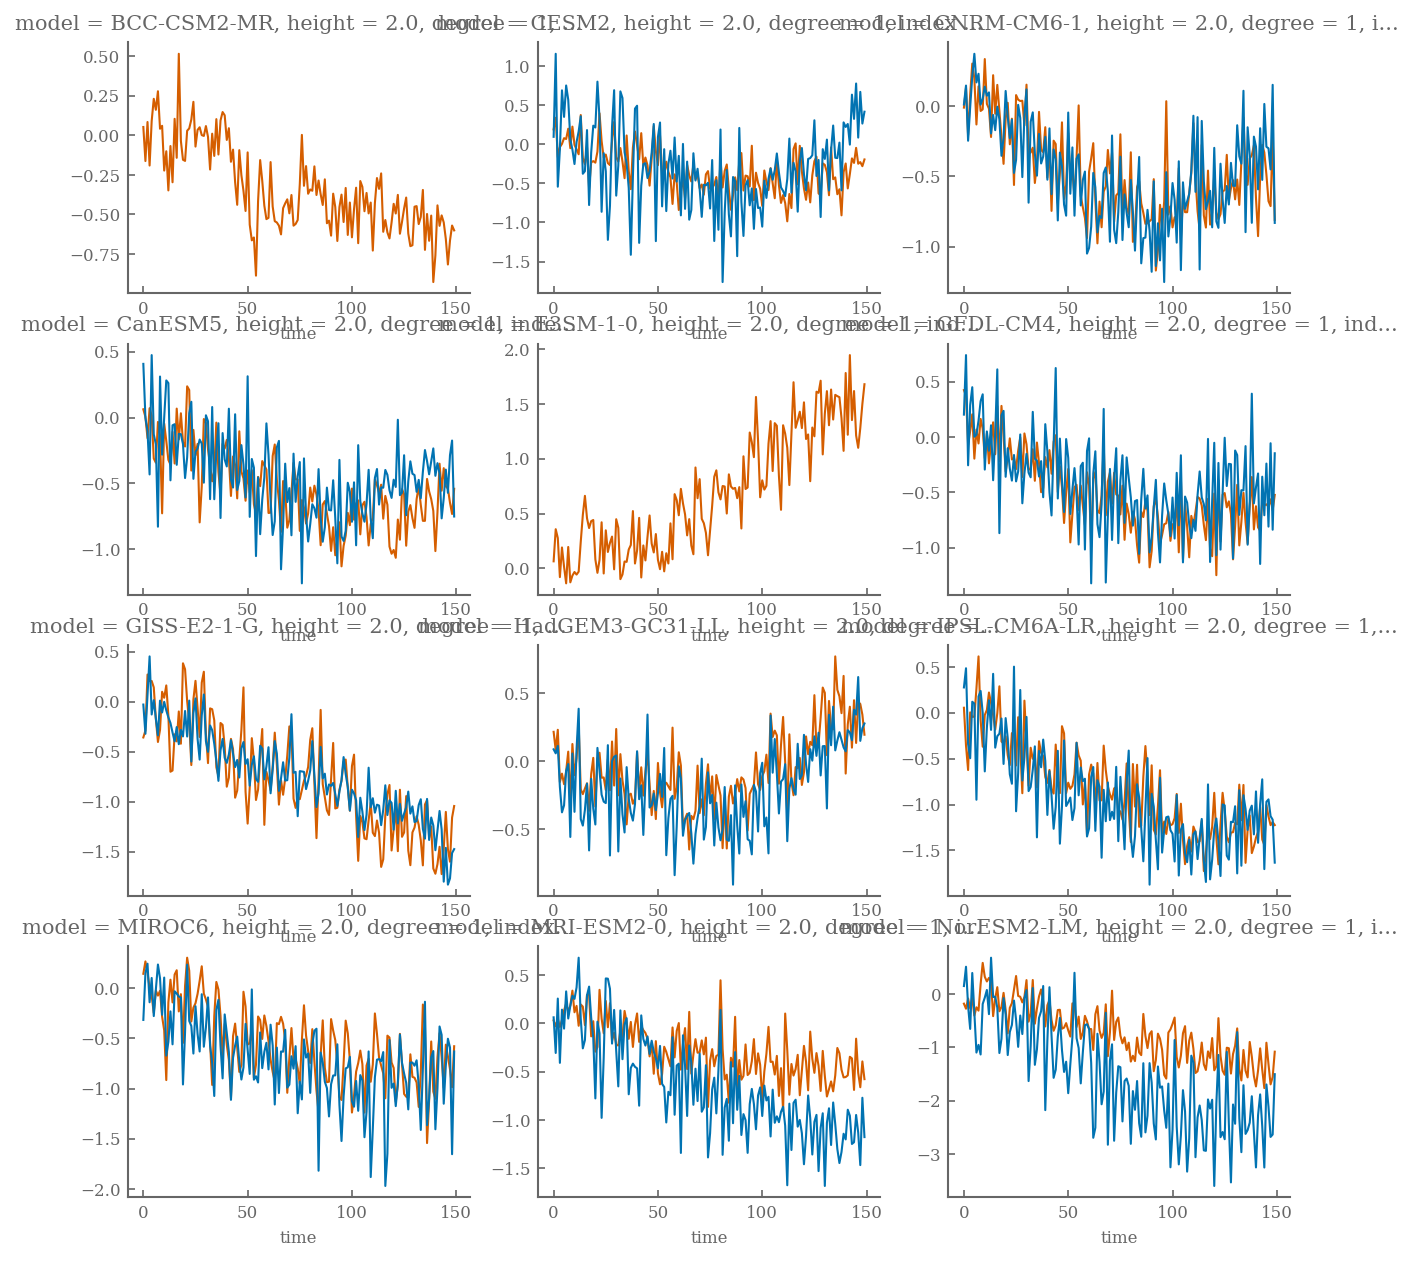

In [257]:
fig, axs = plt.subplots(4,3,figsize=(10,10))
for k,ax in enumerate(axs.flatten()):
    
    ds.isel(model=k).dRp_gf.mean('GF_source').plot(ax=ax, color='C3')
    dP_reco_2.sel(index='mean').isel(model=k).plot(ax=ax)
    # dP_reco_1.isel(model=k).plot(ax=ax)

In [35]:
xr_linregress((lbd_u_amip+sea_ice_feedback.to_xarray().rename(MODEL="model")).mean('method'),ds.lbd_u, dim='model')

<xarray.Dataset> Size: 56B
Dimensions:    ()
Coordinates:
    height     float64 8B 2.0
    degree     int64 8B 1
Data variables:
    slope      float64 8B 0.7096
    intercept  float64 8B -0.2419
    r_value    float64 8B 0.9659
    p_value    float64 8B 3.444e-07
    std_err    float64 8B 0.06018